In [ ]:
# Librerías 
import numpy as np 
import scipy.fft as sft 
import matplotlib.pyplot as plt
from PIL import Image as im

In [ ]:
def tajada(M1,M2,x,y):
    """
    Esta funcion permite recortar una seccion centrada en x, y del array M1 de
    tamaño igual al array M2. Las coordenadas x,y son dadas en un sistema cartesiano centrado.

    Parameters
    ----------
    M1 : Array Numpy
        Arreglo del que se recorta una sección.
    M2 : Array Numpy
        Arreglo que determina el tamaño del recorte.
    x : Integer
        Coordenada en x del centro del recorte en un sistema cartesiano centrado para M1.
    y : Integer
        Coordenada en y del centro del recorte en un sistema cartesiano centrado para M1..

    Raises
    ------
    ValueError
        Si el tamaño del area a recortar o las coordenadas exceden el tamaño de la matriz original se disparara este error.

    Returns
    -------
    MC
        Arreglo de numpy con forma igual a M2.

    """
    (m,n)=M1.shape
    (mm,nn)=M2.shape
    if mm>m or nn>n:
        raise ValueError('La matriz recortada debe ser mas pequeña que la original')
    MC=M1[np.int32(np.ceil((m-mm)*0.5)+y):np.int32(np.ceil((m+mm)*0.5)+y),np.int32(np.ceil((n-nn)*0.5)+x):np.int32(np.ceil((m+nn)*0.5)+x)]
    return MC

def fusion(M1,M2,x,y):
    """
    Esta funcion permite insertar M2 a una seccion centrada en (x, y) del array M1.
    Las coordenadas x,y son dadas en un sistema cartesiano centrado.

    Parameters
    ----------
    M1 : Array Numpy
        Arreglo al que se inserta una sección.
    M2 : Array Numpy
        Arreglo a insertar.
    x : Integer
        Coordenada en x del centro del recorte en un sistema cartesiano centrado para M1.
    y : Integer
        Coordenada en y del centro del recorte en un sistema cartesiano centrado para M1..

    Raises
    ------
    ValueError
        Si el tamaño del area a insertar o las coordenadas exceden el tamaño de la matriz original se disparara este error.

    Returns
    -------
    MC
        Arreglo de numpy con forma igual a M1.

    """
    (m,n)=M1.shape
    (mm,nn)=M2.shape
    if mm>m or nn>n:
        raise ValueError('La matriz a instertar debe ser mas pequeña que la original')
    M1[np.int32(np.ceil((m-mm)*0.5)+y):np.int32(np.ceil((m+mm)*0.5)+y),np.int32(np.ceil((n-nn)*0.5)+x):np.int32(np.ceil((m+nn)*0.5)+x)]=M2
    MC=np.copy(M1)
    return MC

def convft(U,H,dx):
    """
    Realiza la convolucion 2D de las matrices U,H usando la transformada rapida de Fourier. U, H deben tener la misma forma.
    
    Parameters
    ----------
    U : Array Numpy
        Uno de las matrices a convolucionar
    H : Array Numpy
        Otra de las matrices a convolucionar
    dx : Float
        Tamaño de muestreo de las funciones a convolucionar. Necesario para preservar escala.

    Returns
    -------
    U2
        Arreglo de numpy con la convolucio de U y H

    """
    U2=sft.fft2(sft.fftshift(U))*(dx**2)
    U2=H*U2
    U2=sft.ifftshift(sft.ifft2(U2)*(1/dx**2))
    return U2


def circ(x,y,d): # FUNCION CÍRCULO
    out = np.zeros((len(x),len(y)))
    for cont in range(0,len(x)):
        for cont2 in range(0,len(y)):
            out[cont,cont2]=int(np.abs(np.sqrt(x[cont,cont2]**2+y[cont,cont2]**2)/d)<=1)
    return out
    
def propTF(u1,L,lam,z): # PROPAGADOR BASADO EN LA FUNCIÓN DE TRANSFERENCIA
    # propagation - transfer function approach
    # assumes same x and y side lengths and
    # uniform sampling
    # u1 - source plane field
    # L - source and observation plane side length
    # lambda - wavelength
    # z - propagation distance
    # u2 - observation plane field
    N=len(u1[0,:]) 
    dx=L/N
    k=2*np.pi/lam
    fx=np.arange(-1/(dx*2),1/(dx*2),1/L)  
    FX, FY = np.meshgrid(fx, fx);
    H=np.exp(-1j*np.pi*lam*z*(FX**2+FY**2))
    H= np.fft.fftshift(H)
    U1= np.fft.fft2(np.fft.fftshift(u1))
    U2= H*U1
    u2=np.fft.ifftshift(np.fft.ifft2(U2))
    return u2

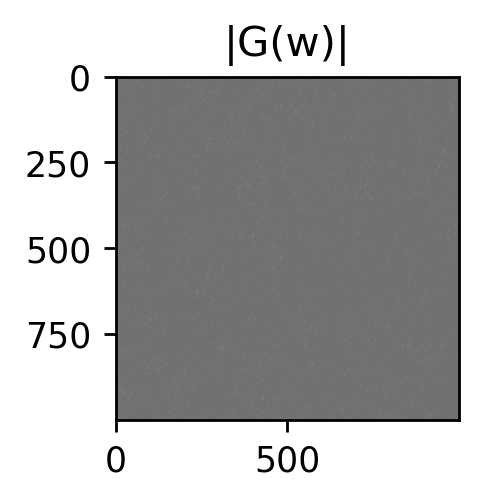

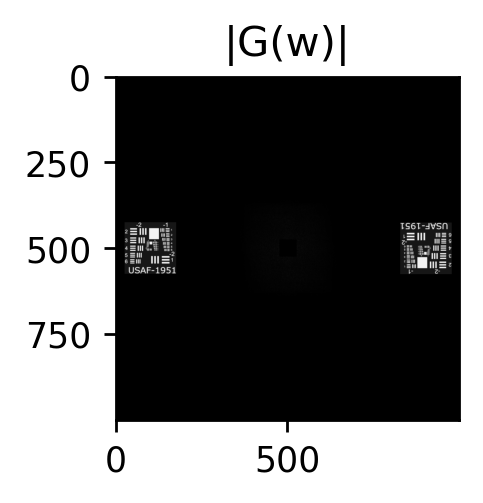

In [ ]:
'''Carguemos la imagen a trabajar'''
I = im.open('./usaf.bmp')

''' 
    Matriz aleatoria con valores arbitrarios, con tamaño del objeto, 
    actúa como una máscara de fase aleatoria
'''
A = np.random.rand(150, 150) 

I=I.resize([150,150]) # El objeto solo ocupará este ventana. Es necesario para que haya suficiente espacio a la hora de reconstruir el holograma
I=1-np.asarray(I)     # Cambio de contraste en la imagen usaf. 
I=I*1.                # Convierte nuestro objeto en una matriz de float. 

'''Normalicemos la imagen'''
I=I/np.max(np.max(I))
I=I-np.min(np.min(I))

'''Multiplicando la matriz por una máscara de fase aleatoria
    La siguiente línea nos muestra lo que comunmente se conoce como
    Objeto Difuso
'''
I = np.sqrt(I)* np.exp(1j*2*np.pi*A) #Campo de entrada I= Campo entrada



'''Campo de Entrada'''
ug=np.zeros([1000,1000])*1j #Campo de ceros, ventana 1000 x 1000 muestras. 

'''
    Ahora al campo de entrada vamos a pegarle la amplitud del objeto y una fase
    proporcional a este. Se pega a -200 muestras del centro de la ventana de 1000 x1000
    muestras. 

'''
ug=fusion(ug,I,-200,0) #Pegamos el campo(objeto difuso) en el campo de entrada

'''
    Marcamos un pixel con 1 en la dirección opuesta, simulando nuestra fuente
    puntual'Hologramas de Gabor', se pone en la dirección opuesta a la cual 
    insertamos el objeto. 
    
    *1000 es para que la intensidad de la fuente puntual realice una buena interferencia
    con el objeto. 
'''
ug=fusion(ug,np.ones([1,1])*1000,200,0)


'''
    Transformada de Fourier de la ventana de entrada(campo de entrada). La transformada de este campo
    es la interferencia entre la transformada de la luz transmitida o reflejada por el objeto y la la 
    transformada de la fuente puntual. Esto es lo que se conoce como Holograma. 
'''

'''
    una onda de referencia y una onda reflejada o transmitida por un objeto interfieren
    sobre un medio que registra la intensidad de dicha interferencia.la intensidad de la interferencia
    de ambos campos en el plano de registro se define como el Holograma. 
'''

Uf = sft.fftshift(sft.fft2(sft.fftshift(ug))) 
H=Uf*np.conj(Uf) #Amplitud de la transformada 
H=abs(H)         #El abs() para asegurarnos de que no hayan errores de computo. 

'''Transformada para la reconstrucción del objeto'''
ui=sft.fftshift(sft.fft2(sft.fftshift(H)))
'''
    Se pone un filtro en el orden central de la reconstrucción para que 
    la visibilidad del objeto sea buena, dado que la intensidad de este orden
    central es muy alto
'''
ui=fusion(ui,np.zeros([50,50]),0,0)

'''Graficación '''
fig = plt.figure(dpi=250) # --> Gráfica de lo que registraría la camara CCD
ax1 = fig.add_subplot(2, 1, 1)
pos1 =ax1.imshow(H,cmap='gray')
ax1.title.set_text('|G(w)|')

fig = plt.figure(dpi=250)
ax1 = fig.add_subplot(2, 1, 2)
pos1 =ax1.imshow(np.abs(ui),cmap='gray')
ax1.title.set_text('|G(w)|')

Text(0.5, 1.0, 'Imagen filtrada')

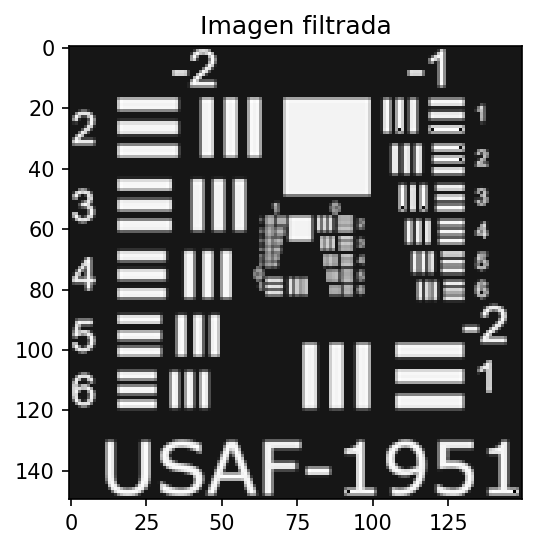

In [ ]:
# Dato filtrado
ug_filtrado=tajada(np.abs(ui),np.zeros([150,150]),-400,0)

plt.figure(dpi=150)
plt.imshow(ug_filtrado, cmap='gray')
plt.title('Imagen filtrada')

# Cuantización: 

(1000, 1000)


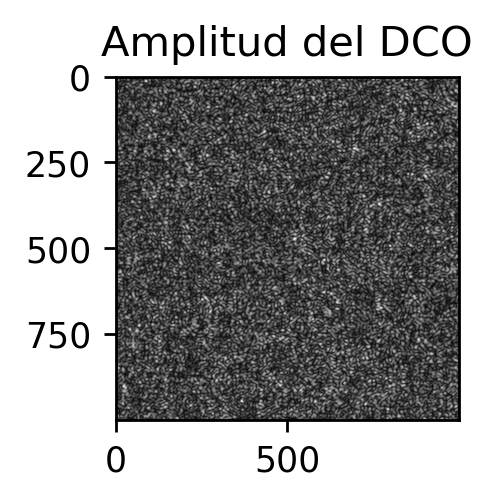

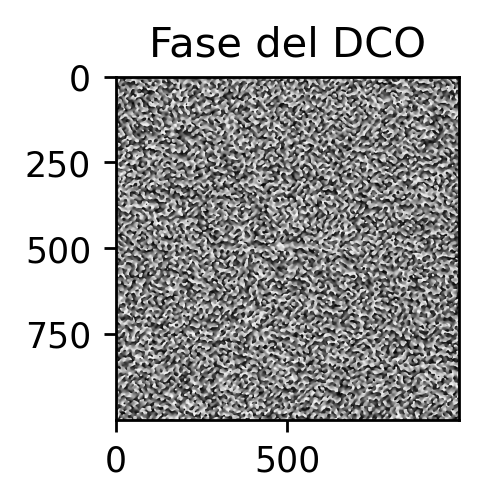

In [ ]:
'''Proceso de Filtrado'''
R=tajada(ui,np.zeros([150,150]),-400,0)

'''Ventana de entrada'''
ug=np.zeros([1000,1000])*1j
ug=fusion(ug,R,0,0) #Pegamos la imagen recortada en la mitad de la ventana

'''Dato de campo óptico'''
DCO=sft.fftshift(sft.fft2(sft.fftshift(ug))) #--> Campo que utilizaremos para la técnica de escalado óptico
print(np.shape(DCO))
'''Amplitud del dato de campo óptico'''
amplitud_DCO = np.abs(DCO)
amplitud_DCO = amplitud_DCO/np.max(np.max(amplitud_DCO))*1.
amplitud_DCO = amplitud_DCO*255.
'''Fase del dato de campo óptico'''
fase_DCO=(np.angle(DCO)+np.pi)/(2*np.pi)
fase_DCO = fase_DCO*255

fig = plt.figure(dpi=250) # --> Gráfica de lo que registraría la camara CCD
ax1 = fig.add_subplot(2, 1, 1)
pos1 =ax1.imshow(amplitud_DCO,cmap='gray')
ax1.title.set_text('Amplitud del DCO')

fig = plt.figure(dpi=250)
ax1 = fig.add_subplot(2, 1, 2)
pos1 =ax1.imshow(fase_DCO,cmap='gray')
ax1.title.set_text('Fase del DCO')

In [ ]:
def quantize(U,bits): 
    '''
        La función quantize se ingresa un campo normalizado y con valores entre 0 y 255.
    '''
    bits = 2**bits 
    x1 = np.linspace(0,255,256) #Arreglo que representa los niveles de intensidad a 8 bits. 
    x2 = np.linspace(0, 255, bits) #Creó el arreglo con el que vamos a cuantizar
    '''
        Dado que introducimos una imagen bidimensional entonces debemos debemos cuantizar los valores de cada
        una de estas, mediante un muestreo uniforme. 
    '''
    Matrix = np.zeros([len(U),len(U)])
    for i in range(0,len(U)): 
        B = U[i,:]
        C = x2[np.absolute(B[:,np.newaxis]-x2).argmin(axis=1)] #Proceso de redondeo
        Matrix[i,:]= C
    
    return Matrix

In [ ]:
'''Aplico la cuantización sobre la amplitud del DCO'''
B = quantize(amplitud_DCO, 2)
B = B/255
'''Aplico la cuantización sobre la fase del DCO'''
C = quantize(fase_DCO,2)
C = C/255
#print(B)
#print(C)
#print(np.shape(B))
#print(np.shape(C))

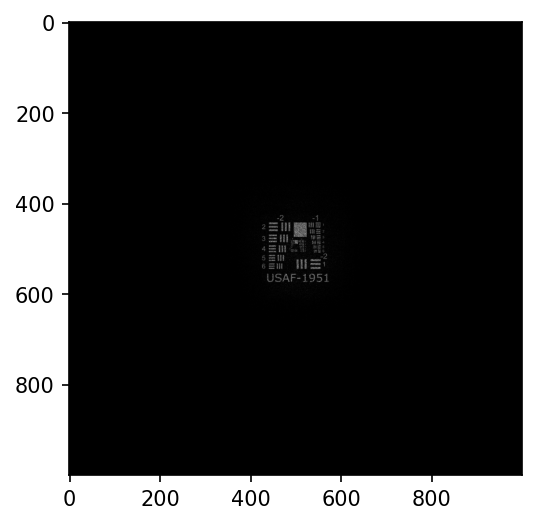

In [ ]:
'''Uno la amplitud_DCO cuantizada con la fase_DCO cuantizada y realizó el proceso de recontrucción'''
'''
    Proceso para la Reconstrucción del objeto a partir del DCO
'''
DCO2=B*np.exp(1j*2*np.pi*(C-0.5)) #para la reconstrucción de la imagen

Re=sft.fftshift(sft.ifft2(sft.fftshift(DCO2)))

reconstruccion = Re*np.conj(Re)
reconstruccion = abs(reconstruccion)

plt.figure(dpi=150)
plt.imshow(reconstruccion, cmap='gray')

Text(0.5, 1.0, 'Imagen cuantizada 2 bits')

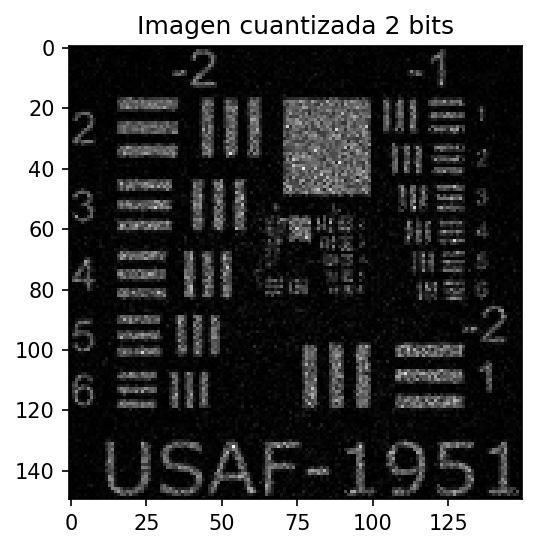

In [ ]:
# Dato filtrado
ug_cuantizado=tajada(reconstruccion,np.zeros([150,150]),0,0)

plt.figure(dpi=150)
plt.imshow(ug_cuantizado, cmap='gray')
plt.title('Imagen cuantizada 2 bits')

In [ ]:
#Implementación coeficiente de correlación 
def corr2(A,B):
    e=0
    s1=0
    s2=0
    Am=np.mean(A)
    Bm=np.mean(B)
    [n,m]=np.shape(A)
    for i in range(0,n):
        for j in range(0,m):
            e=e+(A[i,j]-Am)*(B[i,j]-Bm)
            s1=s1+(A[i,j]-Am)**2
            s2=s2+(B[i,j]-Bm)**2
    s=np.sqrt(s1*s2)
    return e/s

c1 = corr2(ug_filtrado, ug_cuantizado)
print(c1, ':coeficiente de correlación entre las imágenes')

0.9165374643312406 :coeficiente de correlación entre las imágenes


## Gráfica coeficientes de correlación cuantización 

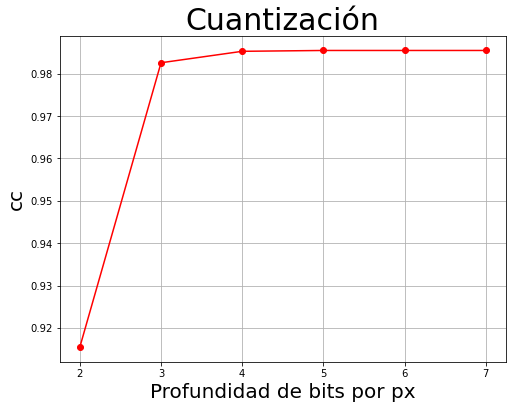

In [ ]:
bits = np.array((7,6,5,4,3,2))
cc = np.array((0.9855,0.9855,0.9855,0.9853,0.9826,0.9155))

plt.figure(figsize=(8,6))
plt.plot(bits,cc,color='red',marker='o')
plt.title('Cuantización', fontsize=30)
plt.xlabel('Profundidad de bits por px', fontsize=20)
plt.ylabel('cc', fontsize=20)
plt.grid()

## Volumen de información en una imagen: 
Para calcular el volumen de información en una imagen podemos utilizar la ecuación: 
$$V = 2*X_o*Y_o*B_c$$
Donde $X_o$ y $Y_o$ representan la resolución horizontal y vertical respectivamente. Además, $B_c$ representa la profundidad de bits utilizada. También es importante tener en cuenta el factor de conversión $1$ Byte = $8$ bits

In [ ]:
Byte = np.array((0.87,0.75,0.62,0.5,0.37,0.25))
lista=[]
def V_cuantizacion(Byte): 
    Xo = 1000 #px, resolución horizontal del DCO
    Yo = 1000 # px, resolución vertical del DCO 
    for i in Byte:
        V = float(2*Xo*Yo*i)
        lista.append(V)
        V_cuantizacion = np.array(lista)
        
    return V_cuantizacion

In [ ]:
A=V_cuantizacion(Byte)*1e-6 #MegaByte
print(A)

[1.74 1.5  1.24 1.   0.74 0.5 ]


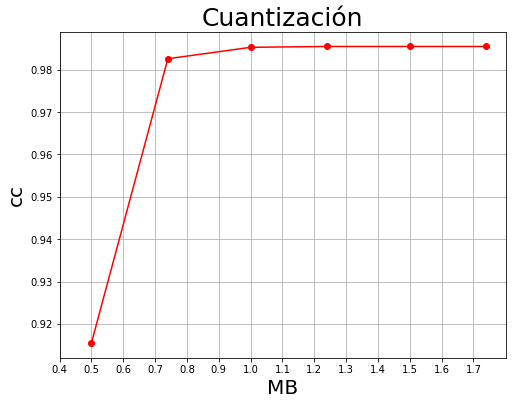

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(A,cc,color='red',marker='o')
plt.title('Cuantización',fontsize=25)
plt.xlabel('MB', fontsize=20)
plt.ylabel('cc', fontsize=20)
plt.xticks(np.arange(0.4,1.8,0.1))
plt.grid()